# Task 2:
# Itamar Melnik- 207312307
# Tomer Sabag- 318814977
# Github : https://github.com/Itamar-Melnik/ML-project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold, RandomizedSearchCV,KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import f_regression,f_classif, mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet,LinearRegression,ElasticNetCV
import ppscore as pps
import statsmodels.api as sm
from sklearn.pipeline import Pipeline 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures

## Prepare_data function

In [2]:
def prepare_data(dataset):  
    # Dropping irrelevant columns
    dataset = dataset.drop(columns=['Test', 'Supply_score'])  
    
    # Replacing 'None' with NaN
    dataset = dataset.replace('None', np.nan)  # Replacing 'None' with NaN
    
    # Standardizing categorical values
    dataset['manufactor'] = dataset['manufactor'].replace('Lexsus', 'לקסוס')  
    dataset['model'] = dataset['model'].replace(r'r/n', '', regex=True)   
    dataset['model'] = dataset['model'].str.replace(r'\(\d+\)', '', regex=True)  
    dataset['model'] = dataset['model'].replace(r'[\r\n()]', '', regex=True)
    dataset['model'] = dataset['model'].str.strip()  # Trimming spaces from model names
    
    dataset['Gear'] = dataset['Gear'].replace('אוטומט', 'אוטומטית')
    dataset['Gear'] = dataset['Gear'].replace('לא מוגדר', np.nan)
    
    # Cleaning numeric columns
    dataset['Km'] = dataset['Km'].replace(',', '')
    dataset['Km'] = pd.to_numeric(dataset['Km'], errors='coerce').astype('Int64')
    
    dataset['capacity_Engine'] = dataset['capacity_Engine'].replace(',', '')
    dataset['capacity_Engine'] = pd.to_numeric(dataset['capacity_Engine'], errors='coerce').astype('Int64')
    
    dataset['Engine_type'] = dataset['Engine_type'].replace('היבריד', 'היברידי')
    
    # Standardizing 'Area' values
    dataset['Area'].replace({
        'נס': 'נס ציונה - רחובות',
        'רמת': 'רמת גן - גבעתיים',
        'ראש': 'ראש העין והסביבה',
        'רעננה': 'רעננה - כפר סבא',
        'חיפה': 'חיפה וחוף הכרמל',
        'חולון': 'חולון - בת ים',
        'נתניה': 'נתניה והסביבה',
        'מודיעין': 'מודיעין והסביבה',
        'פרדס': 'פרדס חנה - כרכור',
        'פתח': 'פתח תקוה והסביבה',
        'הוד': 'הוד השרון והסביבה',
        'רחובות': 'נס ציונה - רחובות',
        'ירושלים': 'ירושלים והסביבה',
        'תל': 'תל אביב',
        'רמלה': 'רמלה - לוד',
        'ראשל"צ': 'ראשל"צ והסביבה',
        'מושבים': 'מושבים בשרון',
        'עמק': 'עמק יזרעאל',
        'גליל': 'גליל ועמקים'
    }, inplace=True)
    
    dataset[['Prev_ownership', 'Curr_ownership']] = dataset[['Prev_ownership', 'Curr_ownership']].replace(['לא מוגדר', 'אחר'], np.nan)
    
    dataset[['Cre_date', 'Repub_date']] = dataset[['Cre_date', 'Repub_date']].apply(pd.to_datetime, errors='coerce')  # Converting 'Date' column to datetime format
    
    # Function to convert engine capacity
    def convert_capacity(x):
        if pd.isna(x):
            return x    
        if 100 <= x < 250:
            return x * 10
        elif x >= 10000:
            return x // 10
        else:
            return x
    
    dataset['capacity_Engine'] = dataset['capacity_Engine'].apply(convert_capacity)
    
    # Replace outliers with median
    median_value = dataset.capacity_Engine.median()
    dataset['capacity_Engine'] = dataset['capacity_Engine'].apply(lambda x: median_value if pd.notna(x) and (x < 600 or x > 8000) else x)
    dataset['capacity_Engine'] = pd.to_numeric(dataset['capacity_Engine'], errors='coerce').astype('Int64')
    
    # Remove outliers in 'Km'
    dataset['Km'] = dataset.groupby('Year')['Km'].transform(lambda x: x.where(x <= 700000, x.median()))
    
    # Fill missing values with mode
    fill_na_columns = ['capacity_Engine', 'Engine_type', 'Gear', 'Km', 'Color']
    group_columns = [
        ['manufactor', 'model', 'Year'],
        ['manufactor', 'model'],
        ['model', 'Year'],
        ['manufactor', 'Year'],
        ['model'],
        ['manufactor']
    ]
    
    for col in fill_na_columns:
        for group in group_columns:
            dataset[col] = dataset.groupby(group)[col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
    
    # Fill 'Area' based on 'City'
    dataset['Area'] = dataset.groupby(['City'])['Area'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
    dataset['Area'].fillna('unknown', inplace=True)
    
    # Fill other missing values
    dataset['Pic_num'].fillna(0, inplace=True)
    
    average_date = dataset['Cre_date'].mean()
    dataset['Cre_date'].fillna(average_date, inplace=True) 
    
    average_date = dataset['Repub_date'].mean()
    dataset['Repub_date'].fillna(average_date, inplace=True) 
    
    # Handle missing values
    for column in dataset.columns:
        if dataset[column].dtype == 'object':
            mode_value = dataset[column].mode().iloc[0]
            dataset[column].fillna(mode_value, inplace=True)
        else:
            median_value = dataset[column].median()
            dataset[column].fillna(median_value, inplace=True)


    
    # Create 'Age_Squared' feature
    dataset['Age_Squared'] = (datetime.now().year - dataset['Year'])**2  # Extracting year from 'Date' column
    
    # Rank categorical features
    gear_ranking = {
        'אוטומטית': 1,
        'טיפטרוניק': 2,
        'ידנית': 3,
        'רובוטית': 4
    }
    
    ownership_ranking = {
        'פרטית': 1,
        'ליסינג': 3,
        'חברה': 3,
        'השכרה': 4
    }
    
    engine_type_ranking = {
        'חשמלי': 1,
        'היברידי': 2,
        'בנזין': 3,
        'טורבו דיזל': 4,
        'דיזל': 5,
        'גז': 6,
    }
    
    dataset['Gear'] = dataset['Gear'].map(gear_ranking)
    dataset['Prev_ownership'] = dataset['Prev_ownership'].replace(ownership_ranking)
    dataset['Curr_ownership'] = dataset['Curr_ownership'].replace(ownership_ranking)
    dataset['Prev_ownership'].fillna(2, inplace=True)
    dataset['Curr_ownership'].fillna(2, inplace=True)
    dataset['Engine_type'] = dataset['Engine_type'].map(engine_type_ranking)
    
    # Create 'Max_ownership' feature
    dataset['Max_ownership'] = dataset[['Prev_ownership', 'Curr_ownership']].max(axis=1)
    dataset.drop(['Prev_ownership', 'Curr_ownership'], axis=1, inplace=True)
    
    # Create binary features
    dataset['Pic_num'] = dataset.Pic_num.apply(lambda x: 1 if x > 0 else 0)
    dataset['Description'] = dataset['Description'].apply(lambda x: 1 if len(x) > 5 else 0)
    
    # Calculate days since 'Cre_date' and 'Repub_date'
    dataset['Cre_date'] = (datetime.now() - dataset['Cre_date']).dt.days
    dataset['Repub_date'] = (datetime.now() - dataset['Repub_date']).dt.days
    
    # Drop irrelevant columns
    dataset = dataset.drop(columns=['City', 'Repub_date'])  # Dropping irrelevant columns 'City' and 'Repub_date'
    
    # Separate features and target variable
    X = dataset.drop(columns=['Price'])  # Separating features from target variable 'Price'
    y = dataset['Price']
    
    # Drop additional columns as per the original request
    X = X.drop(columns=['Description', 'Pic_num', 'Area', 'Max_ownership','Color'])  # Dropping additional columns as specified
    
    # Encode categorical features
    categorical_features = X.select_dtypes(include=['object'])  # Selecting categorical features
    numerical_features = X.select_dtypes(exclude=['object'])  # Selecting numerical features
    
    onehotencoder = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')  # Initializing OneHotEncoder for categorical feature encoding
    X_categorical = onehotencoder.fit_transform(categorical_features)  # Encoding categorical features
    
    # Save the new feature names
    new_categorical_feature_names = onehotencoder.get_feature_names(categorical_features.columns)  # Saving new feature names after encoding
    
    # Calculate frequencies
    frequencies = pd.DataFrame(X_categorical, columns=new_categorical_feature_names).sum(axis=0)  # Creating DataFrame from encoded categorical features
    
    # Define threshold for removal
    threshold = 3  # Defining frequency threshold for feature selection
    
    # Keep columns that are above the threshold
    columns_to_keep = frequencies[frequencies > threshold].index  # Keeping columns with frequency above the threshold
    
    # Filter encoded columns by frequency
    X_categorical_filtered = pd.DataFrame(X_categorical, columns=new_categorical_feature_names)[columns_to_keep]  # Creating DataFrame from encoded categorical features
    
    # Combine numerical and filtered categorical features
    X_numerical = numerical_features.values  
    X_combined = np.hstack((X_numerical, X_categorical_filtered.values))  
    
    # Create list of new feature names
    new_feature_names = list(numerical_features.columns) + list(columns_to_keep)  
    
    # Combine features and target into a single DataFrame
    combined_df = pd.DataFrame(X_combined, columns=new_feature_names)  
    combined_df['Price'] = y.reset_index(drop=True)  
    
    # Return the processed DataFrame
    return combined_df

### Import dataset and function activation


In [3]:
dataset = pd.read_csv('dataset.csv')
processed_df = prepare_data(dataset)

### Dorpping coulmns with  too many null values

In [4]:
dataset = dataset.drop(columns=['Test','Supply_score'])

### Fixing bugs in data

In [5]:
dataset = dataset.replace('None',np.nan)  # Replacing 'None' with NaN

dataset['manufactor'] = dataset['manufactor'].replace('Lexsus','לקסוס')  # Standardizing manufacturer names

dataset['model'] = dataset['model'].replace(r'r/n', '', regex=True)   # Removing 'r/n' from model names
dataset['model'] = dataset['model'].str.replace(r'\(\d+\)', '', regex=True)  # Removing digits and special characters from model names
dataset['model'] = dataset['model'].replace(r'[\r\n()]', '', regex=True)
dataset['model'] = dataset['model'].str.strip()  # Trimming spaces from model names

dataset['Gear'] = dataset['Gear'].replace('אוטומט','אוטומטית')
dataset['Gear'] = dataset['Gear'].replace('לא מוגדר',np.nan)

dataset['Km'] = dataset['Km'].replace(',', '')
dataset['Km'] = pd.to_numeric(dataset['Km'], errors='coerce').astype('Int64')

dataset['capacity_Engine'] = dataset['capacity_Engine'].replace(',', '')
dataset['capacity_Engine'] = pd.to_numeric(dataset['capacity_Engine'], errors='coerce').astype('Int64')

dataset['Engine_type'] = dataset['Engine_type'].replace('היבריד','היברידי')

# Standardizing 'Area' values
dataset['Area'].replace({
    'נס': 'נס ציונה - רחובות',
    'רמת':'רמת גן - גבעתיים',
    'ראש': 'ראש העין והסביבה',
    'רעננה': 'רעננה - כפר סבא',
    'חיפה': 'חיפה וחוף הכרמל',
    'חולון': 'חולון - בת ים',
    'נתניה': 'נתניה והסביבה',
    'מודיעין': 'מודיעין והסביבה',
    'פרדס': 'פרדס חנה - כרכור',
    'פתח': 'פתח תקוה והסביבה',
    'הוד': 'הוד השרון והסביבה',
    'רחובות': 'נס ציונה - רחובות',
    'ירושלים': 'ירושלים והסביבה',
    'תל': 'תל אביב',
    'רמלה': 'רמלה - לוד',
    'ראשל"צ': 'ראשל"צ והסביבה',
    'מושבים': 'מושבים בשרון',
    'עמק': 'עמק יזרעאל',
    'גליל': 'גליל ועמקים'
}, inplace=True)


dataset[['Prev_ownership','Curr_ownership']] = dataset[['Prev_ownership','Curr_ownership']].replace(['לא מוגדר','אחר'],np.nan)

dataset[['Cre_date','Repub_date']] = dataset[['Cre_date','Repub_date']].apply(pd.to_datetime, errors='coerce')  # Converting 'Date' column to datetime format

### Dealing with outliers

In [6]:
# Standardizing 'capacity_Engine' values
def convert_capacity(x):
    if pd.isna(x):
        return x  
    if 100 <= x < 250:
        return x * 10  # Convert values between 100 and 250 by multiplying by 10
    elif 10000 <= x:
        return x // 10  # Convert values 10000 and above by dividing by 10
    else:
        return x  


dataset['capacity_Engine'] = dataset['capacity_Engine'].apply(convert_capacity)


median_value = dataset.capacity_Engine.median()

# Replace values in 'capacity_Engine' that are less than 600 or greater than 8000 with the median value
dataset['capacity_Engine'] = dataset['capacity_Engine'].apply(lambda x: median_value if pd.notna(x) and (x < 600 or x > 8000) else x)

# Convert 'capacity_Engine' to numeric
dataset['capacity_Engine'] = pd.to_numeric(dataset['capacity_Engine'], errors='coerce').astype('Int64')

# Replace values in 'Km' that are greater than 700000 with the median value for that year
dataset['Km'] = dataset.groupby('Year')['Km'].transform(lambda x: x.where(x <= 700000, x.median()))



### Filling null values

In [7]:
dataset['capacity_Engine'] = dataset.groupby(['manufactor', 'model', 'Year'])['capacity_Engine'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['capacity_Engine'] = dataset.groupby(['manufactor', 'model'])['capacity_Engine'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['capacity_Engine'] = dataset.groupby(['model','Year'])['capacity_Engine'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['capacity_Engine'] = dataset.groupby(['manufactor', 'Year'])['capacity_Engine'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['capacity_Engine'] = dataset.groupby(['model'])['capacity_Engine'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['capacity_Engine'] = dataset.groupby(['manufactor'])['capacity_Engine'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))

dataset['Engine_type'] = dataset.groupby(['manufactor', 'model', 'Year','capacity_Engine'])['Engine_type'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['Engine_type'] = dataset.groupby(['manufactor', 'model', 'Year'])['Engine_type'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['Engine_type'] = dataset.groupby(['manufactor', 'model','capacity_Engine'])['Engine_type'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['Engine_type'] = dataset.groupby(['model', 'Year','capacity_Engine'])['Engine_type'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['Engine_type'] = dataset.groupby(['manufactor', 'Year','capacity_Engine'])['Engine_type'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['Engine_type'] = dataset.groupby(['manufactor', 'model'])['Engine_type'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['Engine_type'] = dataset.groupby(['model', 'Year'])['Engine_type'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['Engine_type'] = dataset.groupby(['manufactor', 'Year'])['Engine_type'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))


dataset['Gear'] = dataset.groupby(['manufactor', 'model', 'Year'])['Gear'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['Gear'] = dataset.groupby(['manufactor', 'model'])['Gear'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))

dataset['Km'] = dataset.groupby(['manufactor', 'model', 'Year'])['Km'].fillna(dataset.groupby(['manufactor', 'model', 'Year'])['Km'].transform('median'))
dataset['Km'] = dataset.groupby(['manufactor', 'Year'])['Km'].fillna(dataset.groupby(['manufactor','Year'])['Km'].transform('median'))
dataset['Km'] = dataset.groupby([ 'model', 'Year'])['Km'].fillna(dataset.groupby(['model', 'Year'])['Km'].transform('median'))
dataset['Km'] = dataset.groupby(['Year'])['Km'].fillna(dataset.groupby(['Year'])['Km'].transform('median'))

dataset['Color'] = dataset.groupby(['manufactor', 'model', 'Year'])['Color'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['Color'] = dataset['Color'].fillna(dataset['Color'].mode().iloc[0])

dataset['Area'] = dataset.groupby(['City'])['Area'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x))
dataset['Area'].fillna('unknown', inplace=True)

dataset['Pic_num'].fillna(0, inplace=True)

average_date = dataset['Cre_date'].mean()
dataset['Cre_date'].fillna(average_date, inplace=True) 

average_date = dataset['Repub_date'].mean()
dataset['Repub_date'].fillna(average_date, inplace=True)

### Feature engineering

In [8]:
dataset['Age_Squared'] =(datetime.now().year - dataset['Year'])**2




gear_ranking = {
    'אוטומטית': 1,
    'טיפטרוניק': 2,
    'ידנית': 3,
    'רובוטית': 4
}

ownership_ranking = {
    'פרטית': 1,
    'ליסינג': 3,
    'חברה': 3,
    'השכרה': 4
}

engine_type_ranking = {
    'חשמלי': 1,
    'היברידי': 2,
    'בנזין': 3,
    'טורבו דיזל': 4,
    'דיזל': 5,
    'גז': 6,
}

dataset['Gear'] = dataset['Gear'].map(gear_ranking)


dataset['Prev_ownership'] = dataset['Prev_ownership'].replace(ownership_ranking)
dataset['Curr_ownership'] = dataset['Curr_ownership'].replace(ownership_ranking)
dataset['Prev_ownership'].fillna(2, inplace=True)
dataset['Curr_ownership'].fillna(2, inplace=True)

dataset['Engine_type'] = dataset['Engine_type'].map(engine_type_ranking)

dataset['Max_ownership'] = dataset[['Prev_ownership', 'Curr_ownership']].max(axis=1)
dataset.drop(['Prev_ownership', 'Curr_ownership'], axis=1, inplace=True)

dataset['Pic_num'] = dataset.Pic_num.apply(lambda x: 1 if x > 0  else 0)

dataset['Description'] = dataset['Description'].apply(lambda x: 1 if len(x) > 5 else 0)


dataset['Cre_date'] = (datetime.now() - dataset['Cre_date']).dt.days


dataset['Repub_date'] = (datetime.now()-dataset.Repub_date).dt.days

### Checking multicollinearity with:
#### 1) Sperman corr matrix for int columns type
#### 2) PPS  score matrix  for int and categorical columns type

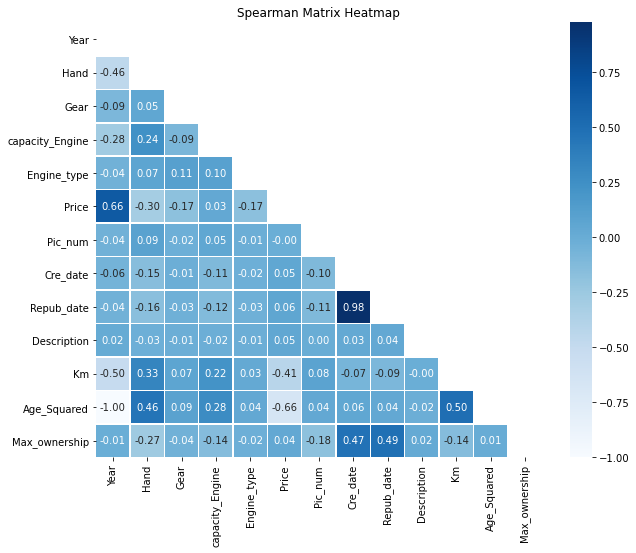

In [9]:
corr_data = dataset.select_dtypes(exclude=['object']).corr(method='spearman')


mask = np.triu(np.ones_like(corr_data, dtype=bool))


plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, mask=mask, cmap='Blues', annot=True, fmt=".2f", linewidths=.5)
plt.title('Spearman Matrix Heatmap')
plt.show()

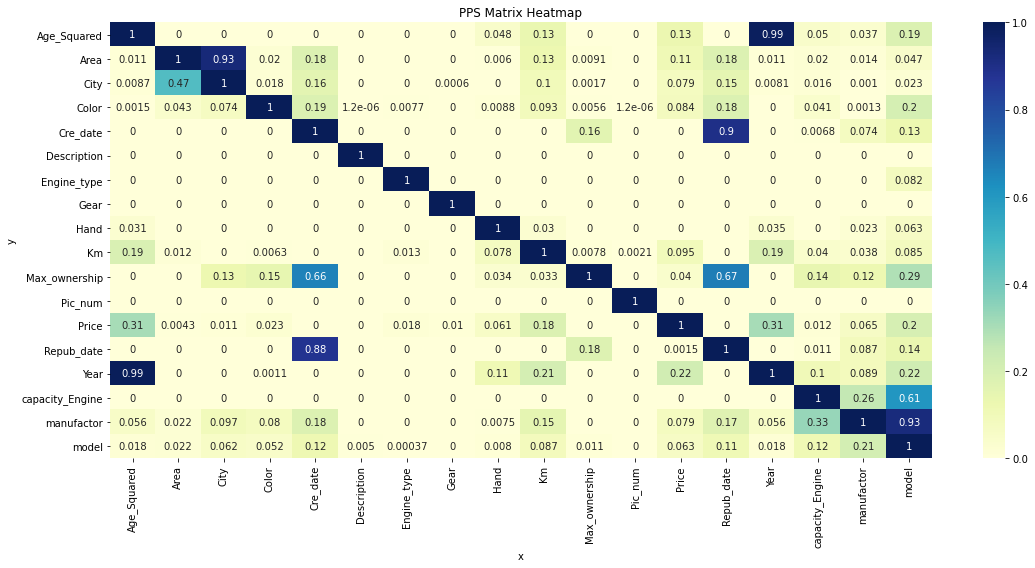

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pps_matrix = pps.matrix(dataset)

# Create a pivot table from the PPS matrix for easier plotting
pps_pivot = pps_matrix.pivot(index='x', columns='y', values='ppscore')

# Create a heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pps_pivot.transpose(), annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('PPS Matrix Heatmap')
plt.tight_layout()
plt.show()

### test conclusions: 
### 1) multicollinearity between Area & City - we decide to remove city because to many errors in city's valus.
### 2)  multicollinearity between Cre_date & Repub_date  - we decide to remove Repub_date  Cre_date is usually more important.
### 3) multicollinearity between manufactor & model - we decide to keep them both because they are important for the model and Elestic net can handle multicollinearity.

In [11]:
dataset = dataset.drop(columns=['City','Repub_date'])

## Feature Selection: 
### 1) Spearman - between numerical features to numerical target
### 2) PPS Score - between all features 
### 3) Mutual Information regression -  between all features
### 4) F Regression ANOVA - between categorical features to numerical target

Price              1.000000
Year               0.659850
Age_Squared        0.659850
Km                 0.414327
Hand               0.300779
Gear               0.174176
Engine_type        0.171501
Cre_date           0.052147
Description        0.049306
Max_ownership      0.035264
capacity_Engine    0.034738
Pic_num            0.004557
Name: Price, dtype: float64


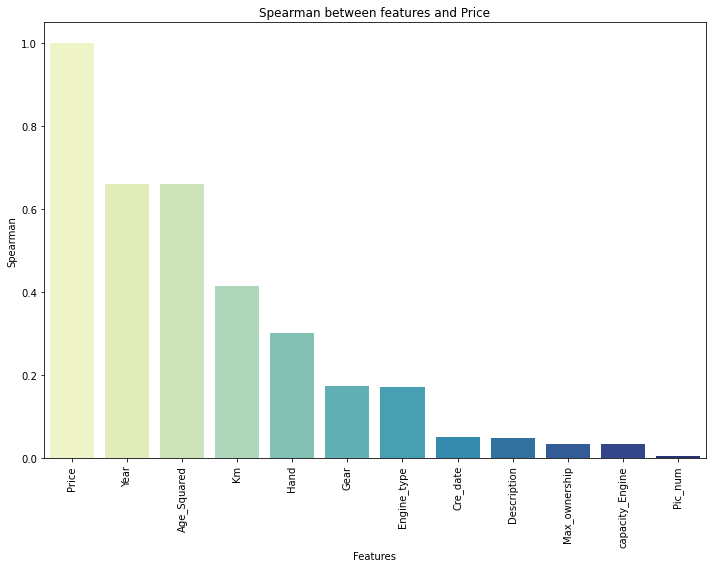

In [12]:
corr_data = dataset.select_dtypes(exclude=['object']).corr(method='spearman')
price_relations_sp = corr_data['Price'].abs().sort_values(ascending=False)
print(price_relations_sp)
plt.figure(figsize=(10, 8))
sns.barplot(x=price_relations_sp.index, y=price_relations_sp.abs().values, palette='YlGnBu')
plt.xticks(rotation=90)
plt.title('Spearman between features and Price')
plt.ylabel('Spearman')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

x
Price              1.000000
Year               0.308262
Age_Squared        0.306840
model              0.201571
Km                 0.184874
manufactor         0.065254
Hand               0.060717
Color              0.023493
Engine_type        0.018356
capacity_Engine    0.012390
Gear               0.010358
Area               0.004278
Cre_date           0.000000
Description        0.000000
Max_ownership      0.000000
Pic_num            0.000000
Name: Price, dtype: float64


<Figure size 720x576 with 0 Axes>

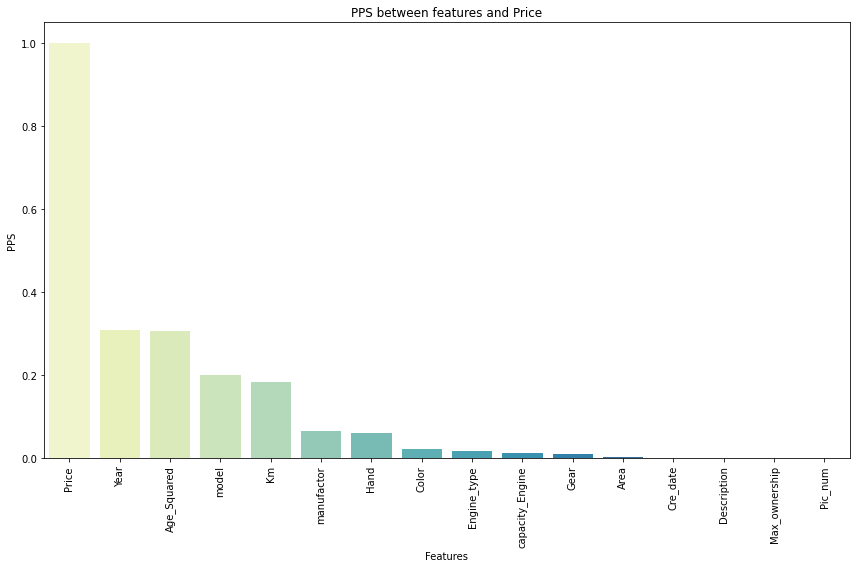

In [13]:
pps_matrix = pps.matrix(dataset)

# Create a pivot table from the PPS matrix for easier plotting
pps_pivot = pps_matrix.pivot(index='x', columns='y', values='ppscore')
# יצירת גרף חום להצגת הקשרים
plt.figure(figsize=(10, 8))
# מיון ה-PPS לפי ערכי המחיר בסדר יורדני
price_relations_pps = pps_pivot['Price'].sort_values(ascending=False)
print(price_relations_pps)
# יצירת גרף בר להצגת הקשרים
plt.figure(figsize=(12, 8))
sns.barplot(x=price_relations_pps.index, y=price_relations_pps.values, palette='YlGnBu')
plt.xticks(rotation=90)
plt.title('PPS between features and Price')
plt.ylabel('PPS')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

In [14]:
X = dataset.drop(columns=['Price'])
y = dataset['Price']

           features     score
0             model  0.725375
1                Km  0.538412
2          Cre_date  0.523034
3              Year  0.466074
4       Age_Squared  0.466074
5        manufactor  0.269098
6              Area  0.247467
7             Color  0.214846
8   capacity_Engine  0.184425
9              Hand  0.124952
10    Max_ownership  0.089552
11      Engine_type  0.064969
12             Gear  0.049551
13          Pic_num  0.022909
14      Description  0.008652 

best_features: ['model', 'Km', 'Cre_date', 'Year', 'Age_Squared', 'manufactor', 'Area', 'Color', 'capacity_Engine', 'Hand', 'Max_ownership', 'Engine_type']


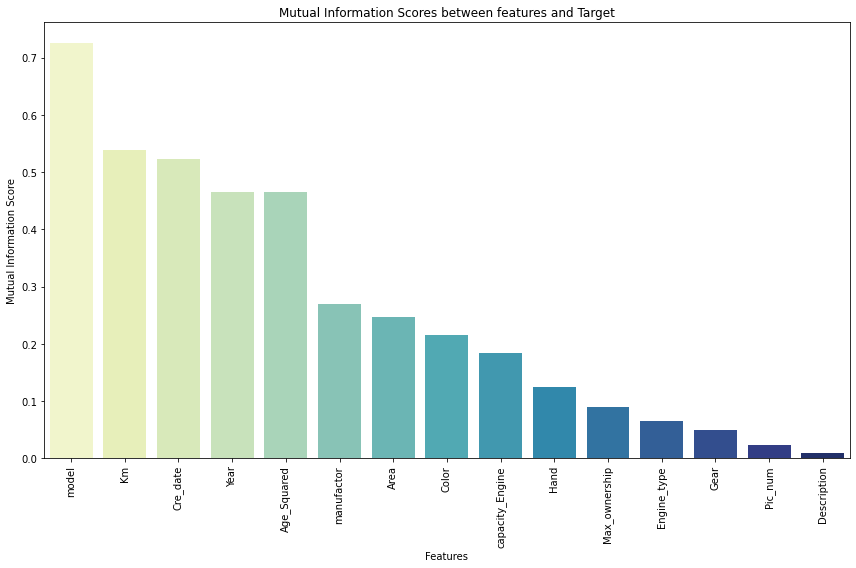

In [15]:
discrete_columns = ['manufactor', 'model', 'Hand', 'Engine_type', 'Area', 'Color', 'Gear', 'Description', 'Pic_num', 'Year', 'Age_Squared']
continuous_columns = ['capacity_Engine', 'Cre_date', 'Km']

# יצירת עותק של X_train כדי להימנע משינוי במקור
X_encoded = X.copy()

# טיפול במשתנים קטגוריים
le = LabelEncoder()
for col in discrete_columns:
    if X_encoded[col].dtype == 'object':
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# יצירת מסכה בוליאנית עבור העמודות הדיסקרטיות
discrete_mask = X_encoded.columns.isin(discrete_columns)

# חישוב ציוני המידע ההדדי
mutual_info = mutual_info_regression(X_encoded, y, discrete_features=discrete_mask)

# שימוש ב-SelectKBest עם mutual_info_regression
selector = SelectKBest(score_func=lambda X_encoded, y: mutual_info, k='all')
selector.fit(X_encoded, y)

# יצירת DataFrame עם תוצאות הבחירה
score = pd.DataFrame({'features': X_encoded.columns, 'score': mutual_info})

# מיון ה-DataFrame לפי ניקוד
score = score.sort_values(by='score', ascending=False).reset_index(drop=True)

# הדפסת התוצאות
print(score, '\n')
print('best_features:', score[score['score'] > 0.05]['features'].tolist())

# יצירת גרף
plt.figure(figsize=(12, 8))
sns.barplot(x='features', y='score', data=score, palette='YlGnBu')
plt.xticks(rotation=90)
plt.title('Mutual Information Scores between features and Target')
plt.ylabel('Mutual Information Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()



        features      score  pValues
0           Gear  46.057913  0.00000
1    Engine_type  23.394513  0.00000
2     manufactor  15.900993  0.00007
3    Description   4.314131  0.03797
4          model   2.152647  0.14253
5  Max_ownership   1.571594  0.21017
6        Pic_num   0.224841  0.63544
7           Area   0.112928  0.73688
8          Color   0.056063  0.81286 

best_features: ['Gear', 'Engine_type', 'manufactor', 'Description']


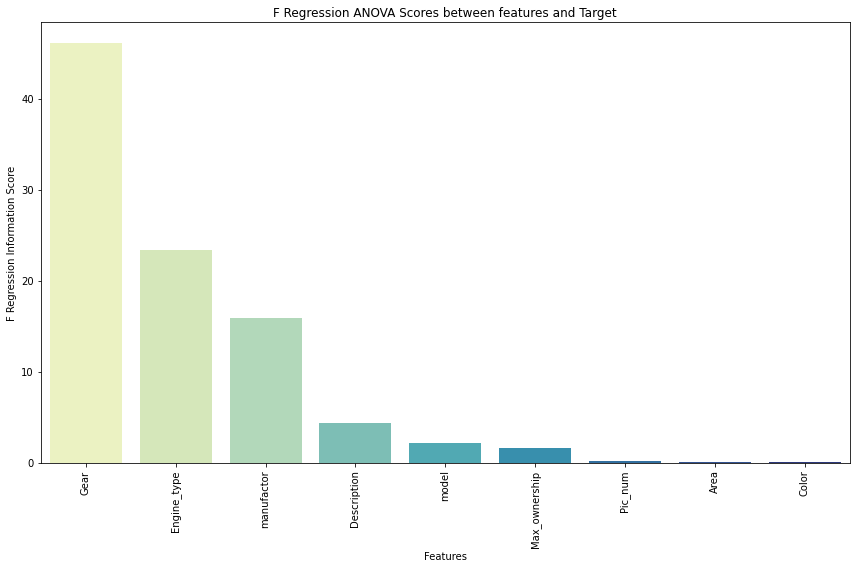

In [16]:
# הנחת DataFrame קיים בשם label_data
label_data = X.copy()

# הצפנת ערכים קטגוריים
le = LabelEncoder()
for column in label_data.columns:
    label_data[column] = le.fit_transform(label_data[column].astype(str))

# הורדת עמודות שאינן רלוונטיות
label_data = label_data.drop(columns=['Km', 'Cre_date', 'Year', 'capacity_Engine','Age_Squared','Hand'])

# הפרדת הנתונים לסטי אימון ובדיקה


# בחירת המאפיינים הטובים ביותר
best_features = SelectKBest(score_func=f_regression, k='all')
selection = best_features.fit(label_data, y)

# יצירת DataFrame עם תוצאות ה-ANOVA
anova_score = pd.DataFrame(zip(label_data.columns, selection.scores_, selection.pvalues_), columns=['features', 'score', 'pValues'])

# מיון ה-DataFrame לפי ניקוד
anova_score = anova_score.sort_values(by='score', ascending=False).reset_index(drop=True)
anova_score['pValues'] = anova_score['pValues'].round(5)
# סינון התוצאות על בסיס pValue
print(anova_score , '\n')
print('best_features:',anova_score[anova_score['pValues'] < 0.05]['features'].tolist())

plt.figure(figsize=(12, 8))
sns.barplot(x='features', y='score', data=anova_score, palette='YlGnBu')
plt.xticks(rotation=90)
plt.title('F Regression ANOVA Scores between features and Target')
plt.ylabel('F Regression Information Score')
plt.xlabel('Features')
plt.tight_layout()
plt.show()


### Conclusions from the graphs:

### According to all the graphs, there is agreement that the columns `pic_num`, `description`, and `max_ownership` should be removed.

### Now let's move on to specific conclusions:

### 1) According to PPS matrix, we exclude all columns whose p-value equals 0, except `cre_date` which is reasonable in other tests.

### 2) In the f test, we decided to lower the importance of the `color` column because its p-value is very low.

In [17]:
X = X.drop(columns=['Description','Pic_num','Area','Max_ownership'])

### motivation to create a new column Age_Squared based on our and statistics knowledge that cars lose more value in the first years (we add it in the feature engineering cell)

In [18]:

# Train models
model1 = LinearRegression().fit(X[['Year']], y)
model2 = LinearRegression().fit(X[['Year', 'Age_Squared']], y)
model3 = LinearRegression().fit(X[['Age_Squared']], y)

# Calculate MSE on test set
mse1 = np.sqrt(mean_squared_error(y, model1.predict(X[['Year']])))
mse2 = np.sqrt(mean_squared_error(y, model2.predict(X[['Year', 'Age_Squared']])))
mse3 = np.sqrt(mean_squared_error(y, model3.predict(X[['Age_Squared']])))

print(f"RMSE on test set (Year only): {mse1}")
print(f"RMSE on test set (Year and Age_Squared): {mse2}")
print(f"RMSE on test set (Age_Squared only): {mse3}")

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X[['Year', 'Age_Squared']].columns
vif_data["VIF"] = [variance_inflation_factor(X[['Year', 'Age_Squared']].values, i) 
                   for i in range(X[['Year', 'Age_Squared']].shape[1])]
print(vif_data)

RMSE on test set (Year only): 18311.589252474376
RMSE on test set (Year and Age_Squared): 16911.113642586763
RMSE on test set (Age_Squared only): 20192.20436523462
       feature       VIF
0         Year  2.028708
1  Age_Squared  2.028708


In [19]:
X = processed_df.drop(columns=['Price'])
y = processed_df['Price']

## Tuning parameters for Elastic net

In [24]:


# יצירת פייפליין
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic_net', ElasticNet(random_state=42))
])

# הגדרת טווח הפרמטרים לחיפוש
param_distributions = {
    'elastic_net__alpha': np.logspace(-4, 1, 50),
    'elastic_net__l1_ratio': np.linspace(0, 1, 20)
}

# הגדרת ה-RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Nested Cross-Validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
nested_scores = cross_val_score(search, X, y, cv=outer_cv, scoring='neg_mean_squared_error')

search.fit(X, y)

print("Best parameters: ", search.best_params_)
print("Best cross-validation score: ", -search.best_score_)
print("Nested CV score: {:.2f} (+/- {:.2f})".format(-nested_scores.mean(), nested_scores.std() * 2))

Best parameters:  {'elastic_net__l1_ratio': 0.5789473684210527, 'elastic_net__alpha': 0.010985411419875584}
Best cross-validation score:  141048630.7835848
Nested CV score: 144016721.27 (+/- 45288421.37)


## Prediction with Elastic Net

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standartization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = ElasticNet(alpha=0.01, l1_ratio=0.9, random_state=42)
model.fit(X_train, y_train)

coefficients = model.coef_


feature_names = X.columns.tolist()

feature_importances = pd.Series(coefficients, index=feature_names)


combined_importances = {}
original_columns = ['model', 'manufactor']

for feature in original_columns:

    combined_importances[feature] = feature_importances[[col for col in feature_names if col.startswith(feature)]].median()


for feature in feature_names:
    if not any(feature.startswith(col) for col in original_columns):
        combined_importances[feature] = feature_importances[feature]

combined_importances = pd.Series(combined_importances).sort_values(ascending=False)

y_pred = model.predict(X_test)

## 10 cross validation

In [22]:
cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_scores = np.sqrt(-cv_scores)
print("Cross-Validation RMSE: ", cv_rmse_scores)
print("Mean Cross-Validation RMSE:", cv_rmse_scores.mean())

Cross-Validation RMSE:  [12833.89856355 11717.61915086 12113.56132227 14431.3725416
 12140.39844067  9651.58131787 12497.04021496 14218.2815367
 11795.55850842 13049.08542728]
Mean Cross-Validation RMSE: 12444.839702419022


### Prediction results

Test RMSE: 10585.42051792331
Test R²: 0.770666683941159


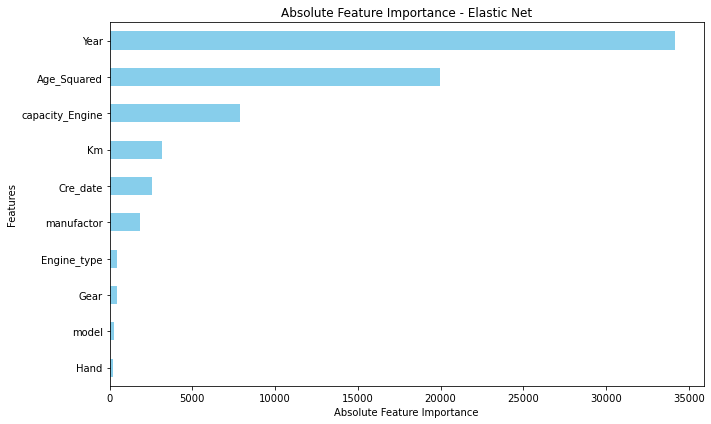

Year               34185.630977
Age_Squared        19965.068180
capacity_Engine     7865.062136
Cre_date            2564.837093
Hand                 174.222265
model               -281.903751
Gear                -440.599071
Engine_type         -443.467162
manufactor         -1814.365207
Km                 -3150.394863
dtype: float64


In [31]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Test RMSE:", rmse)
print("Test R²:", r2)


abs_combined_importances = np.abs(combined_importances)
abs_combined_importances_sorted = abs_combined_importances.sort_values(ascending=True)


plt.figure(figsize=(10, 6))
abs_combined_importances_sorted.plot(kind='barh', color='skyblue')
plt.xlabel('Absolute Feature Importance')
plt.ylabel('Features')
plt.title('Absolute Feature Importance - Elastic Net')
plt.tight_layout()
plt.show()

# הדפסת הערכים המוחלטים
print(combined_importances)

## To summarize the five most important features are:
## 1) Year - positive coefficient
## 2) Age_Squared - positive coefficient
## 3) capacity_Engine - positive coefficient
## 4) Km - negetive coefficient 
## 5) Cre_date - positive coefficient